In [1]:
import pandas as pd

# Load full quantum features
df = pd.read_csv("quantum_raw_parkinsons_gait_percent.csv")

print(f"✅ Loaded full quantum features: {df.shape[1]} columns.")

✅ Loaded full quantum features: 12 columns.


In [2]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Plot
    axs[0].plot(history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[0].set_title(f"Model Accuracy - {title}")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Loss Plot
    axs[1].plot(history.history['loss'], label="Train Loss")
    axs[1].plot(history.history['val_loss'], label="Validation Loss")
    axs[1].set_title(f"Model Loss - {title}")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()

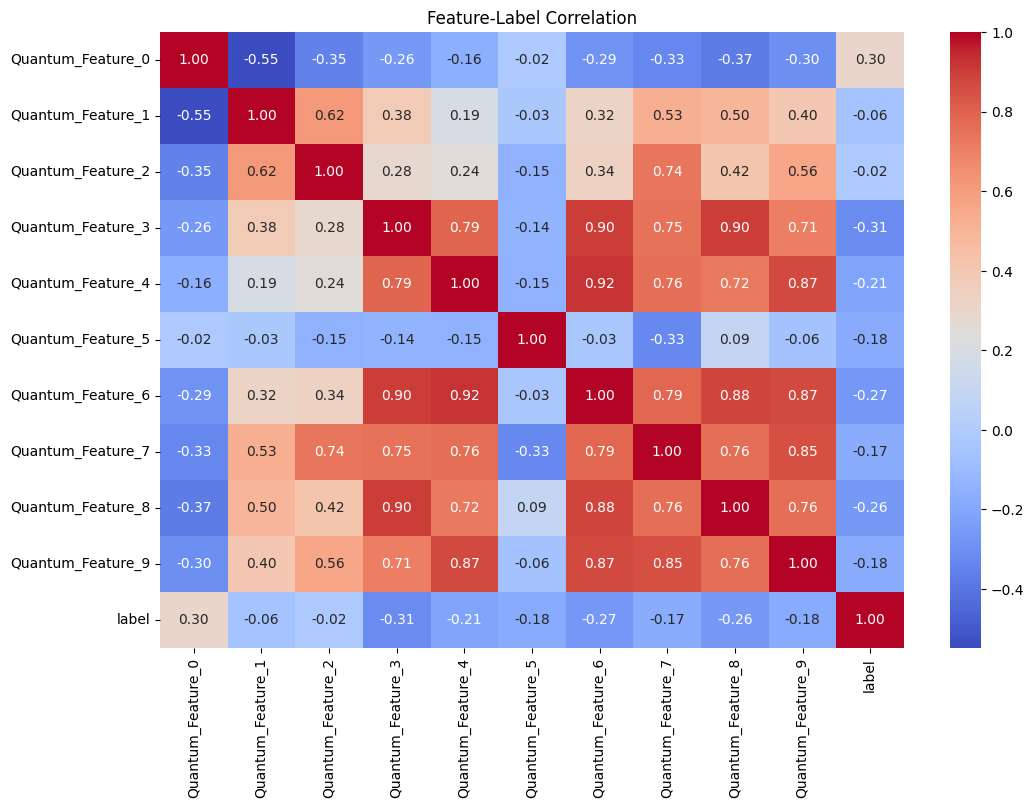

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.drop(columns=["Subject_ID"])
df_corr = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature-Label Correlation")
plt.show()

In [4]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.layers import BatchNormalization, Dropout

tf.keras.backend.set_floatx('float32')

# Ensure features and labels are correctly extracted
X = df.drop(columns=["label"]).values  # Features
y = df["label"].values  # Labels

# Convert labels to one-hot encoding *before* splitting
y_onehot = tf.keras.utils.to_categorical(y, num_classes=2)

# Split once: train + temp
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y_onehot, random_state=42)

# Split again: train + val (from temp)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

# ✅ Remove MinMaxScaler, keep StandardScaler
scaler = StandardScaler()  # StandardScaler ensures proper feature scaling for PCA
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Convert to float32 (required for TensorFlow)
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
y_train = y_train.astype("float32")
X_val = X_val.astype("float32")

print(f"✅ X_train Labels shape: {y_train.shape}, {y_train.shape}")
print(f"✅ X_val Labels shape: {y_val.shape}, {y_val.shape}")
print(f"✅ X_test Labels shape: {y_test.shape}, {y_test.shape}")


✅ X_train Labels shape: (2908,), (2908,)
✅ X_val Labels shape: (970,), (970,)
✅ X_test Labels shape: (970,), (970,)


In [5]:
# Sequential model (LSTM)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train = np.argmax(y_train, axis=1)
    y_test = np.argmax(y_test, axis=1)

# Train
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32, verbose=1)


Epoch 1/20
91/91 [==============================] - 18s 48ms/step - loss: 0.6858 - accuracy: 0.6290 - val_loss: 0.6796 - val_accuracy: 0.6381
Epoch 2/20
91/91 [==============================] - 3s 30ms/step - loss: 0.6701 - accuracy: 0.6499 - val_loss: 0.6596 - val_accuracy: 0.6732
Epoch 3/20
91/91 [==============================] - 3s 30ms/step - loss: 0.6388 - accuracy: 0.7118 - val_loss: 0.6158 - val_accuracy: 0.7351
Epoch 4/20
91/91 [==============================] - 2s 25ms/step - loss: 0.5656 - accuracy: 0.7644 - val_loss: 0.5118 - val_accuracy: 0.8041
Epoch 5/20
91/91 [==============================] - 1s 7ms/step - loss: 0.4582 - accuracy: 0.7999 - val_loss: 0.4252 - val_accuracy: 0.8052
Epoch 6/20
91/91 [==============================] - 1s 7ms/step - loss: 0.3981 - accuracy: 0.8202 - val_loss: 0.3851 - val_accuracy: 0.8330
Epoch 7/20
91/91 [==============================] - 1s 7ms/step - loss: 0.3570 - accuracy: 0.8442 - val_loss: 0.3451 - val_accuracy: 0.8515
Epoch 8/20
91/9

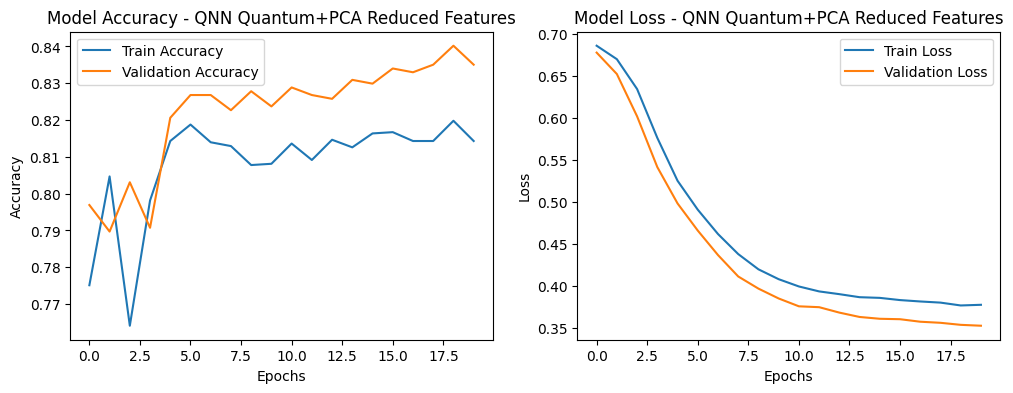

In [11]:
plot_history(history, "QNN Quantum+PCA Reduced Features")

In [6]:
# ✅ Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"QNN Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

31/31 [==============================] - 0s 5ms/step - loss: 0.3394 - accuracy: 0.8454
QNN Test Accuracy: 0.8454 | Loss: 0.3394


31/31 [==============================] - 1s 4ms/step


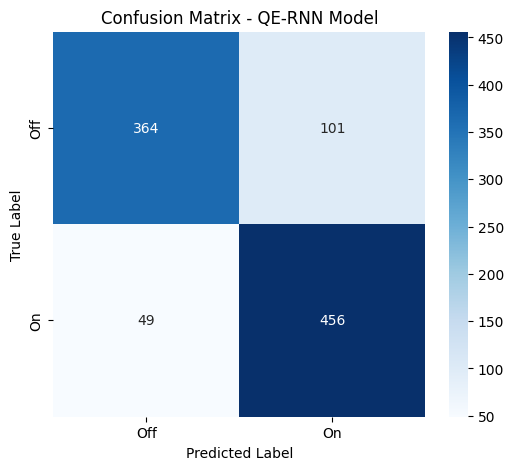

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.78      0.83       465
           1       0.82      0.90      0.86       505

    accuracy                           0.85       970
   macro avg       0.85      0.84      0.84       970
weighted avg       0.85      0.85      0.84       970



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 🔹 Step 1: Get prediction probabilities
y_pred_probs = model.predict(X_test)

# 🔹 Step 2: Binarize predictions (assuming sigmoid output layer)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# 🔹 Step 3: Decode true labels if they're one-hot encoded
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)  # convert [0,1] to 1 and [1,0] to 0

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Off", "On"], yticklabels=["Off", "On"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - QE-RNN Model")
plt.show()

print("Classification Report:\n", classification_report(y_test, y_pred))

# Confidence Check

In [8]:
import numpy as np

# Get model predictions
y_pred_probs = model.predict(X_test)

# Check confidence distribution
print("Min Confidence:", np.min(y_pred_probs))
print("Max Confidence:", np.max(y_pred_probs))
print("Mean Confidence:", np.mean(y_pred_probs))

31/31 [==============================] - 0s 4ms/step
Min Confidence: 0.020534836
Max Confidence: 0.99440247
Mean Confidence: 0.580977


31/31 [==============================] - 0s 3ms/step


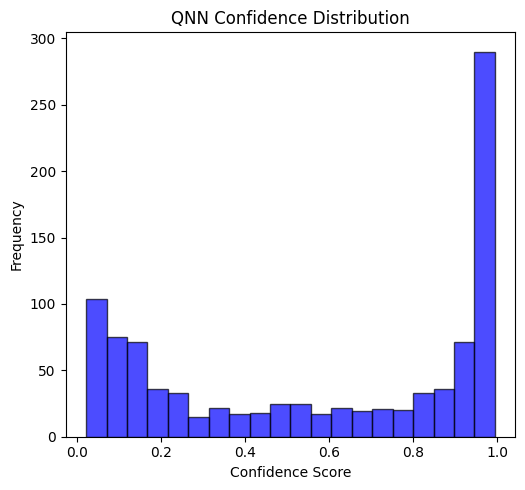

In [9]:
y_true_qnn = y_test# Convert one-hot labels to class labels
y_pred_qnn = np.argmax(model.predict(X_test), axis=1)
confidences_qnn = np.max(model.predict(X_test), axis=1)

# Convert to numpy arrays if needed
qnn_confidences = np.array(confidences_qnn)  # Replace with your QNN confidence list

plt.figure(figsize=(10, 5))

# QNN Confidence Distribution
plt.subplot(1, 2, 1)
plt.hist(qnn_confidences, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("QNN Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# K-Fold

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define number of folds
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Placeholder for epoch-wise averaging
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold+1}/{k}")

    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Define LSTM model
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=0.5),
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    # Train model
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=20, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        verbose=1)

    # Store per-epoch results
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Evaluate model
    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")


Training Fold 1/5
Epoch 1/20
73/73 [==============================] - 3s 17ms/step - loss: 0.6837 - accuracy: 0.6896 - val_loss: 0.6732 - val_accuracy: 0.8230
Epoch 2/20
73/73 [==============================] - 1s 8ms/step - loss: 0.6621 - accuracy: 0.7481 - val_loss: 0.6468 - val_accuracy: 0.7921
Epoch 3/20
73/73 [==============================] - 1s 7ms/step - loss: 0.6341 - accuracy: 0.7223 - val_loss: 0.6162 - val_accuracy: 0.7663
Epoch 4/20
73/73 [==============================] - 0s 7ms/step - loss: 0.6017 - accuracy: 0.7420 - val_loss: 0.5729 - val_accuracy: 0.8351
Epoch 5/20
73/73 [==============================] - 1s 7ms/step - loss: 0.5387 - accuracy: 0.8401 - val_loss: 0.4853 - val_accuracy: 0.8729
Epoch 6/20
73/73 [==============================] - 1s 7ms/step - loss: 0.4339 - accuracy: 0.8534 - val_loss: 0.3661 - val_accuracy: 0.8729
Epoch 7/20
73/73 [==============================] - 1s 7ms/step - loss: 0.3515 - accuracy: 0.8469 - val_loss: 0.3036 - val_accuracy: 0.8694



Final K-Fold Accuracy: 0.8614


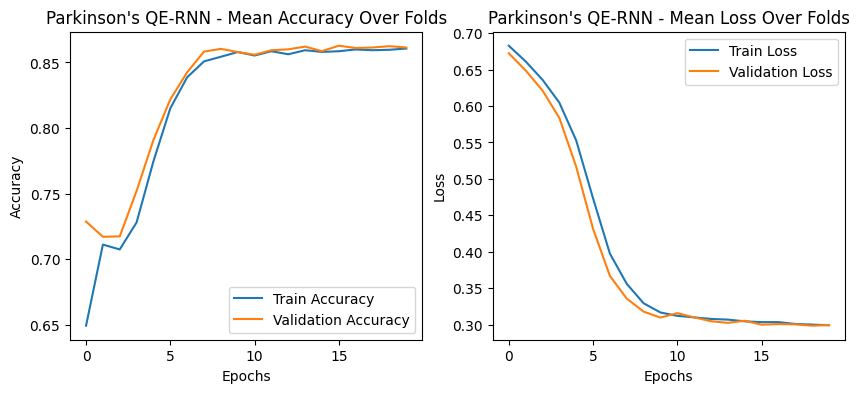

In [11]:
# Convert lists to NumPy arrays for easy averaging
train_accuracies = np.array(train_accuracies)
val_accuracies = np.array(val_accuracies)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# Compute mean accuracy/loss across folds
mean_train_acc = np.mean(train_accuracies, axis=0)
mean_val_acc = np.mean(val_accuracies, axis=0)
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

# 🎯 Final mean accuracy across folds
final_accuracy = np.mean(val_accuracies[:, -1])
print(f"\nFinal K-Fold Accuracy: {final_accuracy:.4f}")

# 📊 Plot Accuracy Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(mean_train_acc, label='Train Accuracy')
plt.plot(mean_val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Parkinson's QE-RNN - Mean Accuracy Over Folds")
plt.legend()

# 📊 Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(mean_train_loss, label='Train Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Parkinson's QE-RNN - Mean Loss Over Folds")
plt.legend()

plt.show()

In [12]:
import pandas as pd
import numpy as np

# Convert lists to numpy arrays
folds = list(range(1, len(train_accuracies) + 1))

# Create DataFrame with results per fold
df_results = pd.DataFrame({
    'Fold': folds,
    'Final Train Accuracy': [train_acc[-1] for train_acc in train_accuracies],
    'Final Validation Accuracy': [val_acc[-1] for val_acc in val_accuracies],
    'Final Train Loss': [train_loss[-1] for train_loss in train_losses],
    'Final Validation Loss': [val_loss[-1] for val_loss in val_losses]
})

# Print results
print("\n📊 K-Fold Cross-Validation Results:\n")
print(df_results)

# Compute summary statistics (mean & std deviation)
df_summary = df_results.describe().loc[['mean', 'std']]
print("\n📌 Summary Statistics (Mean & Std Deviation):\n")
print(df_summary)


📊 K-Fold Cross-Validation Results:

   Fold  Final Train Accuracy  Final Validation Accuracy  Final Train Loss  \
0     1              0.855546                   0.871134          0.306385   
1     2              0.854686                   0.876289          0.301383   
2     3              0.863285                   0.853952          0.304295   
3     4              0.867211                   0.841652          0.287672   
4     5              0.862484                   0.864028          0.295768   

   Final Validation Loss  
0               0.271487  
1               0.288987  
2               0.312639  
3               0.322277  
4               0.301892  

📌 Summary Statistics (Mean & Std Deviation):

          Fold  Final Train Accuracy  Final Validation Accuracy  \
mean  3.000000              0.860642                   0.861411   
std   1.581139              0.005361                   0.013863   

      Final Train Loss  Final Validation Loss  
mean          0.299101             